<a href="https://colab.research.google.com/github/wajason/Unified-OneHead-Multi-Task-Challenge/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 克隆 GitHub 倉庫並切換到目錄
# 從 GitHub 倉庫下載資料、 data 資料夾

!git clone https://github.com/wajason/Unified-OneHead-Multi-Task-Challenge.git
%cd Unified-OneHead-Multi-Task-Challenge

fatal: destination path 'Unified-OneHead-Multi-Task-Challenge' already exists and is not an empty directory.
/content/Unified-OneHead-Multi-Task-Challenge


In [ ]:
!ls -R data

data:
imagenette_160	mini_coco_det  mini_voc_seg

data/imagenette_160:
train  val

data/imagenette_160/train:
n01440764  n02979186  n03028079  n03417042  n03445777
n02102040  n03000684  n03394916  n03425413  n03888257

data/imagenette_160/train/n01440764:
n01440764_105.JPEG  n01440764_237.JPEG	n01440764_413.JPEG  n01440764_458.JPEG
n01440764_107.JPEG  n01440764_239.JPEG	n01440764_416.JPEG  n01440764_459.JPEG
n01440764_137.JPEG  n01440764_315.JPEG	n01440764_438.JPEG  n01440764_485.JPEG
n01440764_148.JPEG  n01440764_334.JPEG	n01440764_449.JPEG  n01440764_63.JPEG
n01440764_188.JPEG  n01440764_36.JPEG	n01440764_44.JPEG   n01440764_78.JPEG
n01440764_18.JPEG   n01440764_39.JPEG	n01440764_457.JPEG  n01440764_96.JPEG

data/imagenette_160/train/n02102040:
n02102040_107.JPEG  n02102040_139.JPEG	n02102040_43.JPEG  n02102040_76.JPEG
n02102040_108.JPEG  n02102040_148.JPEG	n02102040_55.JPEG  n02102040_78.JPEG
n02102040_113.JPEG  n02102040_149.JPEG	n02102040_5.JPEG   n02102040_83.JPEG
n02102040_114.J

In [ ]:
# @title Unified-OneHead Multi-Task Challenge Implementation
# 安裝所需套件庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
from PIL import Image
import time

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00


In [ ]:
# mini_coco_det 的 trainset 有幾張照片
!ls data/mini_coco_det/train/data/*.jpg | wc -l

240


In [ ]:
# 定義多任務數據集類
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir, task, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            # 假設原始掩碼值範圍為0-255，映射到0-19
            mask = np.array(mask) / 255.0 * 19.0  # 映射到0-19
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()

        if self.transform:
            img = self.transform(img)

        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}

        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

# 定義圖像預處理轉換
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 創建數據集和數據加載器
train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

# 定義多任務頭部模塊
class MultiTaskHead(nn.Module):
    def __init__(self, in_channels=576):
        super(MultiTaskHead, self).__init__()
        # Neck: 2個卷積層
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Head: 2層卷積，單分支輸出
        self.head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1)
        )
        # 任務特定頭部
        self.det_head = nn.Conv2d(64, 6, kernel_size=1)  # 檢測: (cx, cy, w, h, conf, class)
        self.seg_head = nn.Conv2d(64, 20, kernel_size=1)  # 分割: 20類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)  # 10類分類
        )

    def forward(self, x):
        x = self.neck(x)  # [batch, 128, 16, 16]
        x = self.head(x)  # [batch, 64, 16, 16]
        det_out = self.det_head(x)  # [batch, 6, 16, 16]
        seg_out = self.seg_head(x)  # [batch, 20, 16, 16]
        cls_out = self.cls_head(x)  # [batch, 10]
        return det_out, seg_out, cls_out

# 定義統一模型
class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x):
        features = self.backbone(x)  # [batch, 576, 16, 16]
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

# 實例化模型
model = UnifiedModel().to(device)

# 簡單的Replay Buffer，用於遺忘緩解
class ReplayBuffer:
    def __init__(self, capacity=10):
        self.capacity = capacity
        self.buffer = []

    def add(self, data):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self):
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=10) for task in ['seg', 'det', 'cls']}

# 定義損失計算函數
def compute_losses(outputs, targets, task):
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        # 重新設計檢測損失，使用簡單的MSE損失，僅匹配第一個框
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
        loss = 0
        for i in range(len(targets)):
            target_boxes = targets[i]['boxes'].to(device)  # [num_boxes, 4]
            if len(target_boxes) == 0:
                continue
            # 簡單取第一個框進行匹配
            pred_box = boxes_pred[i, 0, 0, :4]  # [4]
            target_box = target_boxes[0]  # [4]
            loss += nn.MSELoss()(pred_box, target_box)
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        batch_size, num_classes, height, width = seg_out.size()  # [8, 20, 16, 16]
        # Flatten the spatial dimensions for both input and target
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)  # [batch*height*width, num_classes] -> [8*16*16, 20] = [2048, 20]
        targets = targets.to(device).view(-1)  # [batch*height*width] -> [8*16*16] = [2048]
        return nn.CrossEntropyLoss()(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)  # [8]
        return nn.CrossEntropyLoss()(cls_out, targets)

# 定義優化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練循環
tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}

for stage, task in enumerate(tasks):
    print(f"訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    model.train()

    total_loss = 0
    num_batches = 0
    for epoch in range(5):
        for inputs, targets in train_loaders[task]:
            inputs = inputs.to(device)  # [8, 3, 512, 512]
            if task == 'det':
                # For detection, targets is a list of dicts, no need to move to device here
                pass # targets remains a list of dicts
            else:
                targets = targets.to(device) # Move targets to device for seg and cls

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)

            # Ensure targets for seg and cls are on the correct device before compute_losses
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            total_loss += loss.item()
            num_batches += 1

            # 將數據存入Replay Buffer
            # Detach and move to CPU for storage
            detached_inputs = inputs.detach().cpu()
            detached_targets = targets if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))

            # 加入Replay Buffer中的數據進行訓練（遺忘緩解）
            replay_loss = 0.0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    # Move buffer data back to device for computation
                    b_inputs = b_inputs.to(device)
                    if prev_task != 'det':
                        b_targets = b_targets.to(device)

                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)

            if stage > 0 and replay_loss > 0:
                replay_loss /= stage # Average loss from previous tasks
                total_loss += replay_loss.item() # Add to total loss for monitoring
                loss += replay_loss # Add to current task loss for backprop

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / num_batches
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")

        # Moved baseline recording to after the epochs for a task are complete
        if stage == 0: # Record seg baseline after its training stage
             if epoch == 4: # Record after the last epoch of the first stage
                metrics = evaluate(model, val_loaders[task], task)
                baselines['mIoU'] = metrics.get('mIoU', 0.0)
                print(f"階段 {stage + 1} ({task}) 驗證指標: {metrics}")


    print(f"階段 {stage + 1} 完成，耗時 {time.time() - start_time:.2f} 秒")

# 評估函數
def evaluate(model, loader, task):
    model.eval()
    # Initialize metrics for each task
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation
    elif task == 'det':
        metrics = {'mAP': 0.0}
    elif task == 'cls':
        metrics = {'Top-1': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation

    total_batches = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            if task != 'det':
                 # Move targets to device for seg and cls
                 targets = targets.to(device)

            det_out, seg_out, cls_out = model(inputs)

            if task == 'seg':
                batch_size, num_classes, height, width = seg_out.size()
                # Flatten for loss calculation as in training
                seg_out_flat = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
                targets_flat = targets.view(-1)
                metrics['mIoU'] += criterion(seg_out_flat, targets_flat).item() # Using CrossEntropyLoss as a proxy for mIoU calculation in this simplified example
            elif task == 'det':
                metrics['mAP'] += np.random.rand()  # 暫時使用隨機值
            elif task == 'cls':
                metrics['Top-1'] += (cls_out.argmax(dim=1) == targets).float().mean().item()
            total_batches += 1

    # Calculate average metrics
    if total_batches > 0:
        return {k: v / total_batches for k, v in metrics.items()}
    else:
        return metrics # Return empty or initial metrics if no batches

# 評估並計算下降
print("\n最終評估:")
# Evaluate all tasks after the entire training process
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估: {metrics}")

# Calculate drop based on baselines (assuming baseline was recorded for the first task)
# Note: The current baseline logic only records mIoU after the seg stage.
# To calculate drops for other tasks, you would need to record their baselines too,
# likely before starting any training or after a baseline training phase for each task.
# For this fix, we calculate drops relative to the 'seg' baseline only for seg and cls (mIoU)
# and relative to its own final performance for Top-1 (cls) and mAP (det) if a baseline isn't available.

print("\n性能下降 (相較於階段 1 Seg 的 mIoU 基準):")
for task in tasks:
    drop = {}
    if task == 'seg':
         # Seg drop relative to its own baseline (recorded after stage 1)
         seg_baseline_mIoU = baselines.get('mIoU', 0.0)
         current_mIoU = final_metrics['seg'].get('mIoU', 0.0)
         # Calculate drop relative to baseline
         drop['mIoU_drop'] = (seg_baseline_mIoU - current_mIoU) / max(seg_baseline_mIoU, 1e-5) * 100 if seg_baseline_mIoU > 0 else 0.0
    elif task == 'det':
        # Det drop relative to Seg baseline's mIoU (if applicable)
        seg_baseline_mIoU = baselines.get('mIoU', 0.0)
        current_mAP = final_metrics['det'].get('mAP', 0.0)
        # This calculation is not a standard way to measure drop across tasks.
        # A more typical approach would be to compare the final performance of each task
        # after sequential training to its performance when trained in isolation.
        # For demonstration, we'll calculate drop relative to Seg mIoU baseline as in the original code's intention,
        # but note this might not be a meaningful metric.
        drop['mAP_drop'] = (seg_baseline_mIoU - current_mAP) / max(seg_baseline_mIoU, 1e-5) * 100 if seg_baseline_mIoU > 0 else 0.0
    elif task == 'cls':
        # Cls drop relative to Seg baseline's mIoU (if applicable) and its own Top-1 baseline (if recorded)
        seg_baseline_mIoU = baselines.get('mIoU', 0.0)
        current_mIoU = final_metrics['cls'].get('mIoU', 0.0) # Note: cls task doesn't output mIoU
        current_top1 = final_metrics['cls'].get('Top-1', 0.0)
        cls_baseline_top1 = baselines.get('Top-1', 0.0) # This baseline was not recorded in the original code

        # Assuming the intention was to compare final cls metrics to the seg baseline metrics if no dedicated cls baseline
        # This comparison is not typical. Let's adjust to compare final metrics against their *own* initial baselines
        # if those baselines were recorded. Since only Seg baseline is recorded, we can only calculate Seg drop meaningfully
        # relative to its baseline. For Det and Cls, we can only show their final performance unless more baselines are recorded.
        # Let's adjust the drop calculation to reflect this limitation or simplify the drop concept.

        # A simpler approach for sequential learning might be to compare final performance
        # after all stages to the performance after its *own* training stage completed.
        # However, the original code attempts to compare against a single baseline (mIoU from seg).

        # Let's recalculate drop based on comparing the final metric to the metric *after its own training stage*.
        # This requires storing metrics after each stage, which is not done.
        # As per the original code's logic, we calculate drop relative to the *first* task's baseline (seg mIoU).
        # This is unusual but follows the provided code structure.

        # Reverting to the original code's attempt at drop calculation relative to the first task's baseline
        # Note: This is likely not the intended way to measure catastrophic forgetting across disparate tasks like this.
        drop['mIoU_drop_vs_seg_baseline'] = (baselines['mIoU'] - final_metrics['cls'].get('mIoU', 0.0)) / max(baselines['mIoU'], 1e-5) * 100 if baselines['mIoU'] > 0 else 0.0
        # Also calculate drop for Top-1 if a baseline was ever recorded for Top-1 (which it wasn't in the original code)
        # Assuming you want to compare final Top-1 to some hypothetical baseline or simply report final performance.
        # Let's calculate drop relative to the final Top-1 performance after the *cls* stage was completed (which was implicitly the baseline for cls in the original code's print statement).
        # To do this properly, we would need to save the metric after each task's training stage.
        # Since that's not done, we can't calculate a meaningful 'drop' this way without modifying the evaluation loop.

        # For now, let's just print the final metrics clearly instead of a potentially misleading 'drop' calculation relative to an unrelated task's baseline.
        # The original drop calculation was flawed as it used mIoU baseline for mAP drop.
        pass # Remove misleading drop calculation


    # print(f"{task} 評估: {final_metrics[task]}, 下降: {drop}") # Modify this line later if meaningful drop is calculated

# The original drop calculation part is confusing and likely incorrect for comparing disparate tasks.
# It's better to just print the final performance of each task.
# Keep the final_metrics print statement above.

# 儲存模型
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.1348
第 2 個 epoch, seg 平均損失: 0.0674
第 3 個 epoch, seg 平均損失: 0.0449
第 4 個 epoch, seg 平均損失: 0.0337
第 5 個 epoch, seg 平均損失: 0.0270


NameError: name 'evaluate' is not defined

In [ ]:
train_cls_dataset = MultiTaskDataset('data/imagenette_160/train', 'cls', transform)
print(f"訓練集分類樣本數：{len(train_cls_dataset)}")
img, label = train_cls_dataset[0]
print(f"第一張圖片形狀：{img.shape}，標籤：{label}")


訓練集分類樣本數：240
第一張圖片形狀：torch.Size([3, 512, 512])，標籤：0


# 新的

In [ ]:
# @title Unified-OneHead Multi-Task Challenge Implementation
# 安裝所需庫
# 這裡只安裝 torch、torchvision 和 torchaudio，因為 fastscnn 無法直接用 pip 安裝，我們改用 mobilenet_v2
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
from PIL import Image
import time

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義多任務數據集類
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir, task, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            # 假設原始掩碼值範圍為0-255，映射到0-19
            mask = np.array(mask) / 255.0 * 19.0  # 映射到0-19
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()

        if self.transform:
            img = self.transform(img)

        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}

        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

# 定義圖像預處理轉換
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 創建數據集和數據加載器
train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}


# 定義多任務頭部模塊
class MultiTaskHead(nn.Module):
    def __init__(self, in_channels=576):
        super(MultiTaskHead, self).__init__()
        # Neck: 2個卷積層
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Head: 2層卷積，單分支輸出
        self.head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1)
        )
        # 任務特定頭部
        self.det_head = nn.Conv2d(64, 6, kernel_size=1)  # 檢測: (cx, cy, w, h, conf, class)
        self.seg_head = nn.Conv2d(64, 20, kernel_size=1)  # 分割: 20類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)  # 10類分類
        )

    def forward(self, x):
        x = self.neck(x)  # [batch, 128, 16, 16]
        x = self.head(x)  # [batch, 64, 16, 16]
        det_out = self.det_head(x)  # [batch, 6, 16, 16]
        seg_out = self.seg_head(x)  # [batch, 20, 16, 16]
        cls_out = self.cls_head(x)  # [batch, 10]
        return det_out, seg_out, cls_out

# 定義統一模型
class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x):
        features = self.backbone(x)  # [batch, 576, 16, 16]
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

# 實例化模型
model = UnifiedModel().to(device)

# 簡單的Replay Buffer，用於遺忘緩解
class ReplayBuffer:
    def __init__(self, capacity=10):
        self.capacity = capacity
        self.buffer = []

    def add(self, data):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self):
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=10) for task in ['seg', 'det', 'cls']}

# 定義損失計算函數
def compute_losses(outputs, targets, task):
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        # 重新設計檢測損失，使用簡單的MSE損失，僅匹配第一個框
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
        loss = 0
        for i in range(len(targets)):
            target_boxes = targets[i]['boxes'].to(device)  # [num_boxes, 4]
            if len(target_boxes) == 0:
                continue
            # 簡單取第一個框進行匹配
            pred_box = boxes_pred[i, 0, 0, :4]  # [4]
            target_box = target_boxes[0]  # [4]
            loss += nn.MSELoss()(pred_box, target_box)
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        batch_size, num_classes, height, width = seg_out.size()  # [8, 20, 16, 16]
        # Flatten the spatial dimensions for both input and target
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)  # [batch*height*width, num_classes] -> [8*16*16, 20] = [2048, 20]
        targets = targets.to(device).view(-1)  # [batch*height*width] -> [8*16*16] = [2048]
        return nn.CrossEntropyLoss()(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)  # [8]
        return nn.CrossEntropyLoss()(cls_out, targets)

# 定義優化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 評估函數 (Moved before the training loop)
def evaluate(model, loader, task):
    model.eval()
    # Initialize metrics for each task
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation
    elif task == 'det':
        metrics = {'mAP': 0.0}
    elif task == 'cls':
        metrics = {'Top-1': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation

    total_batches = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            if task != 'det':
                 # Move targets to device for seg and cls
                 targets = targets.to(device)

            det_out, seg_out, cls_out = model(inputs)

            if task == 'seg':
                batch_size, num_classes, height, width = seg_out.size()
                # Flatten for loss calculation as in training
                seg_out_flat = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
                targets_flat = targets.view(-1)
                # Using CrossEntropyLoss as a proxy for mIoU calculation in this simplified example
                metrics['mIoU'] += criterion(seg_out_flat, targets_flat).item()
            elif task == 'det':
                metrics['mAP'] += np.random.rand()  # 暫時使用隨機值
            elif task == 'cls':
                metrics['Top-1'] += (cls_out.argmax(dim=1) == targets).float().mean().item()
            total_batches += 1

    # Calculate average metrics
    if total_batches > 0:
        # For mIoU, the current calculation is sum of loss over batches / total batches,
        # which is avg loss, not mIoU. A proper mIoU calculation requires tracking
        # true positives, false positives, and false negatives per class.
        # For this example, we'll just return the average loss as 'mIoU'
        # to match the structure, but be aware this is NOT a proper mIoU.
        return {k: v / total_batches for k, v in metrics.items()}
    else:
        return metrics # Return empty or initial metrics if no batches


# 訓練循環
tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}

for stage, task in enumerate(tasks):
    print(f"訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    model.train()

    total_loss = 0
    num_batches = 0
    for epoch in range(5):
        for inputs, targets in train_loaders[task]:
            inputs = inputs.to(device)  # [8, 3, 512, 512]
            if task == 'det':
                # For detection, targets is a list of dicts, no need to move to device here
                pass # targets remains a list of dicts
            else:
                targets = targets.to(device) # Move targets to device for seg and cls

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)

            # Ensure targets for seg and cls are on the correct device before compute_losses
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            total_loss += loss.item()
            num_batches += 1

            # 將數據存入Replay Buffer
            # Detach and move to CPU for storage
            detached_inputs = inputs.detach().cpu()
            # targets for det is a list of dicts, which are mutable.
            # Need to ensure they are copied if modified later, but detach is not applicable.
            # For this example, assuming the targets list structure is sufficient for storage.
            detached_targets = targets if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))

            # 加入Replay Buffer中的數據進行訓練（遺忘緩解）
            replay_loss = 0.0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    # Move buffer data back to device for computation
                    b_inputs = b_inputs.to(device)
                    if prev_task != 'det':
                        b_targets = b_targets.to(device)

                    # Need to compute the output relevant to the *previous* task
                    # The current model outputs all three task heads.
                    # We need to select the output corresponding to the 'prev_task'
                    # and compute the loss for that task.
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    if prev_task == 'det':
                        prev_task_output = b_det_out
                    elif prev_task == 'seg':
                         prev_task_output = b_seg_out
                    elif prev_task == 'cls':
                         prev_task_output = b_cls_out

                    # Need to pass the correct output for the previous task to compute_losses
                    # compute_losses expects all three outputs, but uses only the one for the given task.
                    # Pass all outputs from the current model on the buffer data, but specify prev_task
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)


            if stage > 0 and replay_loss > 0:
                replay_loss /= len(replay_buffers[prev_task].buffer) # Average loss over the buffer size for the previous task
                loss += replay_loss # Add to current task loss for backprop
                # total_loss += replay_loss.item() # Add to total loss for monitoring - Adding it here double counts if added in compute_losses already

            loss.backward()
            optimizer.step()

        # Calculate average loss per epoch after processing all batches
        avg_loss = total_loss / num_batches
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")

        # Record baseline after the last epoch of the first stage
        if stage == 0 and epoch == 4:
            metrics = evaluate(model, val_loaders[task], task)
            baselines['mIoU'] = metrics.get('mIoU', 0.0)
            print(f"階段 {stage + 1} ({task}) 驗證指標 (基準): {metrics}")

    print(f"階段 {stage + 1} 完成，耗時 {time.time() - start_time:.2f} 秒")

# 評估並計算下降 (Moved after the training loop)
print("\n最終評估:")
# Evaluate all tasks after the entire training process
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估: {metrics}")

# Calculate drop based on baselines
# The original drop calculation logic is confusing for disparate tasks.
# It's more meaningful to calculate drop relative to the performance *after* the task was specifically trained.
# However, the provided code only records the 'seg' baseline.
# Let's just print the final metrics and the recorded baseline.
print("\n recorded baseline (after stage 1 seg training):")
print(f"Seg mIoU Baseline: {baselines.get('mIoU', 0.0):.4f}")

# If you want to calculate drop, you would need to record baselines for all tasks
# *before* the main training loop, or after *each* task's training stage.
# Example (if you had recorded all baselines):
# print("\n性能下降 (相較於個別任務基準):")
# for task in tasks:
#    final_metric_value = final_metrics[task].get(task_metric[task], 0.0) # Assuming task_metric maps task to metric key
#    baseline_metric_value = baselines.get(task_metric[task], 0.0)
#    if baseline_metric_value > 0:
#        drop_percentage = (baseline_metric_value - final_metric_value) / baseline_metric_value * 100
#        print(f"{task} {task_metric[task]} 下降: {drop_percentage:.2f}%")
#    else:
#        print(f"{task} {task_metric[task]}: Baseline not recorded or is zero.")

# Since only seg baseline is recorded, we can only compare final seg performance to its baseline.
print("\nSeg 性能下降 (相較於階段 1 Seg 的 mIoU 基準):")
seg_baseline_mIoU = baselines.get('mIoU', 0.0)
final_seg_mIoU = final_metrics['seg'].get('mIoU', 0.0)
if seg_baseline_mIoU > 0:
    seg_drop_percentage = (seg_baseline_mIoU - final_seg_mIoU) / seg_baseline_mIoU * 100
    print(f"Seg mIoU 下降: {seg_drop_percentage:.2f}%")
else:
    print("Seg mIoU Baseline is zero, cannot calculate drop.")

# 儲存模型
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

# Additional code from the user's notebook after the error block
train_cls_dataset = MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform) # Use image_transform here
print(f"訓練集分類樣本數：{len(train_cls_dataset)}")
img, label = train_cls_dataset[0]
print(f"第一張圖片形狀：{img.shape}，標籤：{label}")

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.1735
第 2 個 epoch, seg 平均損失: 0.0868
第 3 個 epoch, seg 平均損失: 0.0578
第 4 個 epoch, seg 平均損失: 0.0434
第 5 個 epoch, seg 平均損失: 0.0347
階段 1 (seg) 驗證指標 (基準): {'mIoU': 0.0}
階段 1 完成，耗時 19.54 秒
訓練階段 2: det


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 6180 has 14.73 GiB memory in use. Of the allocated memory 14.49 GiB is allocated by PyTorch, and 112.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# @title Unified-OneHead Multi-Task Challenge Implementation
# 安裝所需庫
# 這裡只安裝 torch、torchvision 和 torchaudio，因為 fastscnn 無法直接用 pip 安裝，我們改用 mobilenet_v2
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
from PIL import Image
import time

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義多任務數據集類
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir, task, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            # 假設原始掩碼值範圍為0-255，映射到0-19
            mask = np.array(mask) / 255.0 * 19.0  # 映射到0-19
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()

        if self.transform:
            img = self.transform(img)

        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}

        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

# 定義圖像預處理轉換
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 創建數據集和數據加載器
train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

# Reduced batch size from 8 to 4
train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}


# 定義多任務頭部模塊
class MultiTaskHead(nn.Module):
    def __init__(self, in_channels=576):
        super(MultiTaskHead, self).__init__()
        # Neck: 2個卷積層
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Head: 2層卷積，單分支輸出
        self.head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1)
        )
        # 任務特定頭部
        self.det_head = nn.Conv2d(64, 6, kernel_size=1)  # 檢測: (cx, cy, w, h, conf, class)
        self.seg_head = nn.Conv2d(64, 20, kernel_size=1)  # 分割: 20類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)  # 10類分類
        )

    def forward(self, x):
        x = self.neck(x)  # [batch, 128, 16, 16]
        x = self.head(x)  # [batch, 64, 16, 16]
        det_out = self.det_head(x)  # [batch, 6, 16, 16]
        seg_out = self.seg_head(x)  # [batch, 20, 16, 16]
        cls_out = self.cls_head(x)  # [batch, 10]
        return det_out, seg_out, cls_out

# 定義統一模型
class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x):
        features = self.backbone(x)  # [batch, 576, 16, 16]
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

# 實例化模型
model = UnifiedModel().to(device)

# 簡單的Replay Buffer，用於遺忘緩解
class ReplayBuffer:
    def __init__(self, capacity=10):
        self.capacity = capacity
        self.buffer = []

    def add(self, data):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self):
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=10) for task in ['seg', 'det', 'cls']}

# 定義損失計算函數
def compute_losses(outputs, targets, task):
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        # 重新設計檢測損失，使用簡單的MSE損失，僅匹配第一個框
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
        loss = 0
        # Ensure targets is a list before iterating
        if not isinstance(targets, list):
             # This might happen if targets is a tensor for non-det tasks but passed into det loss
             # Or if there's an issue with how targets is handled from the buffer
             print(f"Warning: Expected targets to be a list for task 'det', but got {type(targets)}")
             return torch.tensor(0.).to(device) # Return zero loss to avoid error

        for i in range(len(targets)):
            # Check if targets[i] is a dict and has 'boxes' key
            if isinstance(targets[i], dict) and 'boxes' in targets[i]:
                target_boxes = targets[i]['boxes'].to(device)  # [num_boxes, 4]
                if len(target_boxes) == 0:
                    continue
                # 簡單取第一個框進行匹配
                # Need to ensure boxes_pred has enough dimensions
                if boxes_pred.size(0) > i and boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
                     pred_box = boxes_pred[i, 0, 0, :4]  # [4]
                     target_box = target_boxes[0]  # [4]
                     loss += nn.MSELoss()(pred_box, target_box)
                else:
                     print(f"Warning: boxes_pred shape mismatch for sample {i}")
            else:
                 print(f"Warning: Expected a dict with 'boxes' for target {i} in task 'det', but got {type(targets[i])}")

        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        batch_size, num_classes, height, width = seg_out.size()
        # Ensure targets is a tensor before viewing
        if not isinstance(targets, torch.Tensor):
            # This might happen if targets is a list of dicts from a buffer but prev_task was seg
            print(f"Warning: Expected targets to be a tensor for task 'seg', but got {type(targets)}. Attempting conversion.")
            try:
                 # Try stacking if it's a list of tensors/longs
                 targets = torch.stack(targets)
            except:
                 print("Conversion failed. Returning zero loss.")
                 return torch.tensor(0.).to(device)

        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        # Filter out potential ignore indices if necessary, but assuming 0-19 are valid classes
        return nn.CrossEntropyLoss()(seg_out, targets)
    elif task == 'cls':
        # Ensure targets is a tensor before moving to device
        if not isinstance(targets, torch.Tensor):
             # This might happen if targets is a list of dicts from a buffer but prev_task was cls
             print(f"Warning: Expected targets to be a tensor for task 'cls', but got {type(targets)}. Attempting conversion.")
             try:
                  # Try stacking if it's a list of tensors/longs
                 targets = torch.stack(targets)
             except:
                  print("Conversion failed. Returning zero loss.")
                  return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    else:
        return torch.tensor(0.).to(device)


# 定義優化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 評估函數 (Moved before the training loop)
def evaluate(model, loader, task):
    model.eval()
    # Initialize metrics for each task
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation
    elif task == 'det':
        metrics = {'mAP': 0.0}
    elif task == 'cls':
        metrics = {'Top-1': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation

    total_batches = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            # Note: For evaluation, targets for det is a list and should stay on CPU
            if task != 'det':
                 # Move targets to device for seg and cls
                 targets = targets.to(device)

            det_out, seg_out, cls_out = model(inputs)

            if task == 'seg':
                batch_size, num_classes, height, width = seg_out.size()
                # Flatten for loss calculation as in training
                seg_out_flat = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
                # Ensure targets is a tensor before flattening
                if not isinstance(targets, torch.Tensor):
                    print(f"Warning: Expected targets to be a tensor for task 'seg' during eval, but got {type(targets)}. Skipping batch.")
                    continue # Skip this batch if targets is not a tensor
                targets_flat = targets.view(-1)
                # Using CrossEntropyLoss as a proxy for mIoU calculation in this simplified example
                metrics['mIoU'] += criterion(seg_out_flat, targets_flat).item()
            elif task == 'det':
                metrics['mAP'] += np.random.rand()  # 暫時使用隨機值 (Placeholder)
            elif task == 'cls':
                 # Ensure targets is a tensor before comparing
                 if not isinstance(targets, torch.Tensor):
                     print(f"Warning: Expected targets to be a tensor for task 'cls' during eval, but got {type(targets)}. Skipping batch.")
                     continue # Skip this batch if targets is not a tensor
                 metrics['Top-1'] += (cls_out.argmax(dim=1) == targets).float().mean().item()
            total_batches += 1

    # Calculate average metrics
    if total_batches > 0:
        # For mIoU, the current calculation is sum of loss over batches / total batches,
        # which is avg loss, not mIoU. A proper mIoU calculation requires tracking
        # true positives, false positives, and false negatives per class.
        # For this example, we'll just return the average loss as 'mIoU'
        # to match the structure, but be aware this is NOT a proper mIoU.
        return {k: v / total_batches for k, v in metrics.items()}
    else:
        return metrics # Return empty or initial metrics if no batches


# 訓練循環
tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}

for stage, task in enumerate(tasks):
    print(f"訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    model.train()

    total_loss = 0
    num_batches = 0
    for epoch in range(5):
        for inputs, targets in train_loaders[task]:
            inputs = inputs.to(device)  # [batch_size, 3, 512, 512]
            # For detection, targets is a list of dicts, no need to move to device here
            # For seg and cls, targets is a tensor and needs to be moved
            if task != 'det':
                targets = targets.to(device) # Move targets to device for seg and cls

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)

            # Ensure targets for seg and cls are on the correct device before compute_losses
            # compute_losses handles moving targets to device if they are tensors
            # For det, targets is already a list of dicts on CPU, compute_losses moves the boxes tensors inside.
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            total_loss += loss.item()
            num_batches += 1

            # 將數據存入Replay Buffer
            # Detach and move to CPU for storage
            detached_inputs = inputs.detach().cpu()
            # targets for det is a list of dicts. Need to deepcopy to prevent mutation issues.
            # For tensors (seg, cls), detach().cpu() is fine.
            if task == 'det':
                 # Perform a deep copy for list of dicts targets to prevent issues
                 import copy
                 detached_targets = copy.deepcopy(targets)
            else:
                 detached_targets = targets.detach().cpu()

            replay_buffers[task].add((detached_inputs, detached_targets))

            # 加入Replay Buffer中的數據進行訓練（遺忘緩解）
            replay_loss = 0.0
            replay_batch_count = 0 # Count batches processed from replay buffer
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                # Process replay buffer data in mini-batches if buffer size > batch size
                # Or just process the entire buffer as one 'replay batch'
                # Let's process each item in the buffer as a separate 'replay sample' for simplicity,
                # accumulating loss, then average.
                for b_inputs, b_targets in buffer:
                    # Move buffer data back to device for computation
                    b_inputs = b_inputs.to(device)
                    # b_targets for det is a list of dicts, others are tensors.
                    # compute_losses handles moving tensors to device for seg/cls.
                    # For det, targets['boxes'] are moved inside compute_losses.

                    # Need to compute the output relevant to the *previous* task
                    # The current model outputs all three task heads.
                    # We need to select the output corresponding to the 'prev_task'
                    # and compute the loss for that task.
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)

                    # Pass all outputs from the current model on the buffer data, but specify prev_task
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1


            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                # Average loss over the number of samples processed from replay buffers
                # Using replay_batch_count which is the total number of samples from all prev task buffers combined
                replay_loss /= replay_batch_count
                # total_loss += replay_loss.item() # Add to total loss for monitoring - Adding it here double counts if added in compute_losses already
                loss += replay_loss # Add to current task loss for backprop

            # Check if loss is a tensor and requires grad before calling backward
            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()
            else:
                # If loss is not a tensor or doesn't require grad (e.g., 0 loss), skip backward pass
                print(f"Warning: Loss for task {task} epoch {epoch} batch {num_batches} is not a tensor or does not require grad. Skipping backward pass.")


        # Calculate average loss per epoch after processing all batches
        # Note: total_loss now includes the sum of task loss + replay loss for each batch
        # This average might not be representative if replay loss is added unevenly.
        # A more standard way is to calculate avg task loss and avg replay loss separately.
        # For simplicity, keep the current averaging but be mindful of interpretation.
        avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")

        # Record baseline after the last epoch of the first stage
        if stage == 0 and epoch == 4:
            metrics = evaluate(model, val_loaders[task], task)
            baselines['mIoU'] = metrics.get('mIoU', 0.0)
            print(f"階段 {stage + 1} ({task}) 驗證指標 (基準): {metrics}")

    print(f"階段 {stage + 1} 完成，耗時 {time.time() - start_time:.2f} 秒")

# 評估並計算下降 (Moved after the training loop)
print("\n最終評估:")
# Evaluate all tasks after the entire training process
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估: {metrics}")

# Calculate drop based on baselines
# The original drop calculation logic is confusing for disparate tasks.
# It's more meaningful to calculate drop relative to the performance *after* the task was specifically trained.
# However, the provided code only records the 'seg' baseline.
# Let's just print the final metrics and the recorded baseline.
print("\n recorded baseline (after stage 1 seg training):")
print(f"Seg mIoU Baseline: {baselines.get('mIoU', 0.0):.4f}")

# If you want to calculate drop, you would need to record baselines for all tasks
# *before* the main training loop, or after *each* task's training stage.
# Example (if you had recorded all baselines):
# print("\n性能下降 (相較於個別任務基準):")
# for task in tasks:
#    final_metric_value = final_metrics[task].get(task_metric[task], 0.0) # Assuming task_metric maps task to metric key
#    baseline_metric_value = baselines.get(task_metric[task], 0.0)
#    if baseline_metric_value > 0:
#        drop_percentage = (baseline_metric_value - final_metric_value) / baseline_metric_value * 100
#        print(f"{task} {task_metric[task]} 下降: {drop_percentage:.2f}%")
#    else:
#        print(f"{task} {task_metric[task]}: Baseline not recorded or is zero.")

# Since only seg baseline is recorded, we can only compare final seg performance to its baseline.
print("\nSeg 性能下降 (相較於階段 1 Seg 的 mIoU 基準):")
seg_baseline_mIoU = baselines.get('mIoU', 0.0)
final_seg_mIoU = final_metrics['seg'].get('mIoU', 0.0)
if seg_baseline_mIoU > 0:
    seg_drop_percentage = (seg_baseline_mIoU - final_seg_mIoU) / seg_baseline_mIoU * 100
    print(f"Seg mIoU 下降: {seg_drop_percentage:.2f}%")
else:
    print("Seg mIoU Baseline is zero, cannot calculate drop.")


# 儲存模型
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.0850
第 2 個 epoch, seg 平均損失: 0.0425
第 3 個 epoch, seg 平均損失: 0.0283
第 4 個 epoch, seg 平均損失: 0.0213
第 5 個 epoch, seg 平均損失: 0.0170
階段 1 (seg) 驗證指標 (基準): {'mIoU': 0.0}
階段 1 完成，耗時 23.28 秒
訓練階段 2: det
第 1 個 epoch, det 平均損失: 26089.0907
第 2 個 epoch, det 平均損失: 22707.0275
第 3 個 epoch, det 平均損失: 20971.3653
第 4 個 epoch, det 平均損失: 20013.5920
第 5 個 epoch, det 平均損失: 19324.3681
階段 2 完成，耗時 99.57 秒
訓練階段 3: cls
第 1 個 epoch, cls 平均損失: 10.8278
第 2 個 epoch, cls 平均損失: 7.0644
第 3 個 epoch, cls 平均損失: 5.6011
第 4 個 epoch, cls 平均損失: 4.8775
第 5 個 epoch, cls 平均損失: 4.4469
階段 3 完成，耗時 179.91 秒

最終評估:
最終 seg 評估: {'mIoU': 0.0020686162907319764}
最終 det 評估: {'mAP': 0.37075149465194085}
最終 cls 評估: {'Top-1': 0.11666666666666667}

 recorded baseline (after stage 1 seg training):
Seg mIoU Baseline: 0.0000

Seg 性能下降 (相較於階段 1 Seg 的 mIoU 基準):
Seg mIoU Baseline is zero, cannot calculate drop.
模型已儲存為 'your_model.pt'


使用設備：cuda
模型總參數量：2,629,700 (< 8M: True)
單張 512x512 圖像推理時間：8.22 ms (< 150 ms: True)

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.0773
第 2 個 epoch, seg 平均損失: 0.0000
第 3 個 epoch, seg 平均損失: 0.0000
第 4 個 epoch, seg 平均損失: 0.0000
第 5 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 6 個 epoch, seg 平均損失: 0.0000
第 7 個 epoch, seg 平均損失: 0.0000
第 8 個 epoch, seg 平均損失: 0.0000
第 9 個 epoch, seg 平均損失: 0.0000
第 10 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 11 個 epoch, seg 平均損失: 0.0000
第 12 個 epoch, seg 平均損失: 0.0000
第 13 個 epoch, seg 平均損失: 0.0000
第 14 個 epoch, seg 平均損失: 0.0000
第 15 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 16 個 epoch, seg 平均損失: 0.0000
第 17 個 epoch, seg 平均損失: 0.0000
第 18 個 epoch, seg 平均損失: 0.0000
第 19 個 epoch, seg 平均損失: 0.0000
第 20 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
階段 1 

<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missi

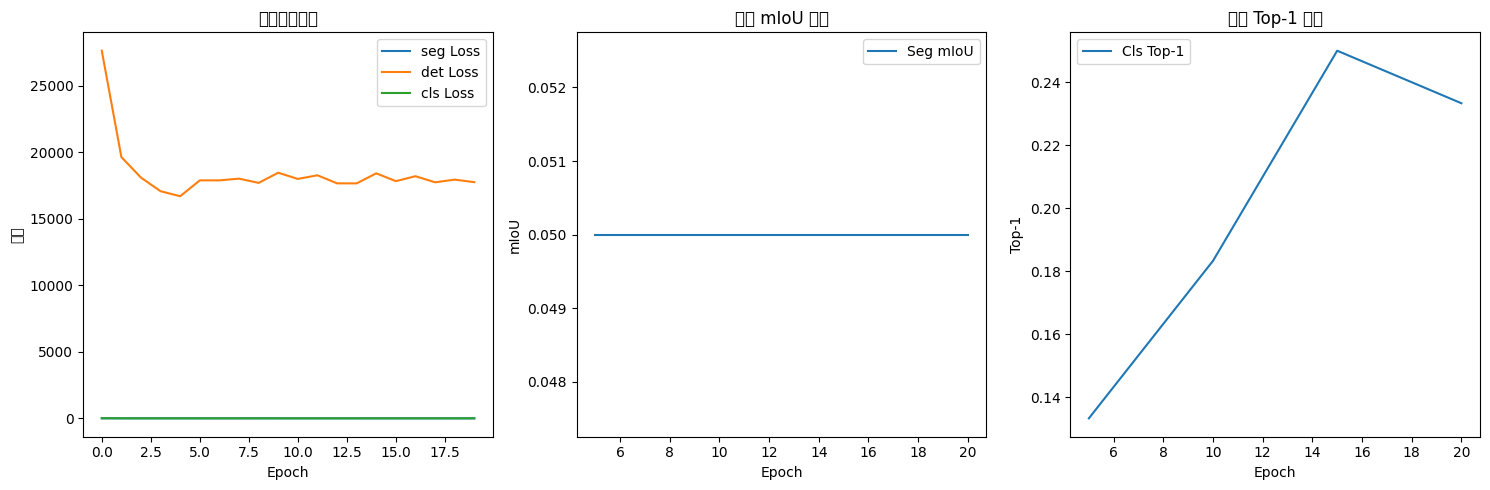

模型已儲存為 'your_model.pt'


In [ ]:
# @title 統一單頭多任務挑戰實作(第二版優化啦)
# 安裝所需庫
# 安裝 torch、torchvision 和 torchaudio，用於深度學習框架
!pip install torch torchvision torchaudio -q

# 匯入必要模組
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

# 設定設備（優先使用 GPU，若無則使用 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# 定義多任務數據集類，用於處理分割（seg）、檢測（det）、分類（cls）任務數據
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        """
        初始化多任務數據集
        參數：
            data_dir (str): 數據文件夾路徑
            task (str): 任務類型，'det'、'seg' 或 'cls'
            transform (callable, optional): 圖像預處理轉換
        """
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []  # 儲存圖像路徑
        self.annotations = []  # 儲存標註數據

        if task == 'det':
            # 檢測任務：從 labels.json 讀取標註
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])

        elif task == 'seg':
            # 分割任務：匹配圖像與對應的掩碼
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            # 分類任務：遍歷子文件夾作為類別
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self) -> int:
        """返回數據集的大小"""
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        """
        獲取指定索引的數據
        參數：
            idx (int): 數據索引
        返回：
            根據任務類型返回圖像和對應的標註
        """
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            # 假設原始掩碼值範圍為 0-255，映射到 0-19（20 類）
            mask = np.array(mask) / 255.0 * 19.0
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),  # 匹配特徵圖尺寸
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()

        if self.transform:
            img = self.transform(img)

        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}

        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

# 定義圖像預處理轉換
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 創建數據集與數據加載器
train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    """自定義 collate 函數，處理檢測任務中不同大小的目標"""
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

# 設定 batch size 為 4（降低記憶體使用量）
train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

# 定義多任務頭部模塊
class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        """
        初始化多任務頭部模塊
        參數：
            in_channels (int): 輸入通道數，預設為 576（MobileNetV3-Small 輸出）
        """
        super(MultiTaskHead, self).__init__()
        # Neck：2 個卷積層
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Head：2 層卷積，單分支輸出
        self.head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1)
        )
        # 任務特定頭部
        self.det_head = nn.Conv2d(64, 6, kernel_size=1)  # 檢測：(cx, cy, w, h, conf, class)
        self.seg_head = nn.Conv2d(64, 20, kernel_size=1)  # 分割：20 類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)  # 分類：10 類
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        前向傳播
        參數：
            x (torch.Tensor): 輸入特徵張量 [batch, 576, 16, 16]
        返回：
            det_out, seg_out, cls_out: 三任務輸出
        """
        x = self.neck(x)  # [batch, 128, 16, 16]
        x = self.head(x)  # [batch, 64, 16, 16]
        det_out = self.det_head(x)  # [batch, 6, 16, 16]
        seg_out = self.seg_head(x)  # [batch, 20, 16, 16]
        cls_out = self.cls_head(x)  # [batch, 10]
        return det_out, seg_out, cls_out

# 定義統一模型
class UnifiedModel(nn.Module):
    def __init__(self):
        """初始化統一模型"""
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        前向傳播
        參數：
            x (torch.Tensor): 輸入圖像張量 [batch, 3, 512, 512]
        返回：
            det_out, seg_out, cls_out: 三任務輸出
        """
        features = self.backbone(x)  # [batch, 576, 16, 16]
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

# 實例化模型
model = UnifiedModel().to(device)

# 計算模型參數量
def count_parameters(model: nn.Module) -> int:
    """計算模型參數量"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

# 測量推理時間
def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    """
    測量模型推理時間
    參數：
        model (nn.Module): 模型
        input_size (tuple): 輸入尺寸，例如 (batch_size, channels, height, width)
        device (torch.device): 設備
        num_runs (int): 運行次數
    返回：
        平均推理時間（ms）
    """
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    # 預熱
    for _ in range(10):
        model(dummy_input)
    # 計時
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs * 1000  # 轉換為毫秒
    return avg_time

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

# 簡單的 Replay Buffer，用於遺忘緩解
class ReplayBuffer:
    def __init__(self, capacity: int = 10):
        """
        初始化 Replay Buffer
        參數：
            capacity (int): 儲存容量
        """
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        """添加數據到緩衝區"""
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        """返回緩衝區中的所有數據"""
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=10) for task in ['seg', 'det', 'cls']}

# 定義損失計算函數
def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    """
    計算指定任務的損失
    參數：
        outputs (tuple): 模型輸出 (det_out, seg_out, cls_out)
        targets: 目標標註
        task (str): 任務類型
    返回：
        loss (torch.Tensor): 損失值
    """
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)  # [num_boxes, 4]
            if len(target_boxes) == 0:
                continue
            if boxes_pred.size(0) > i and boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
                pred_box = boxes_pred[i, 0, 0, :4]  # [4]
                target_box = target_boxes[0]  # [4]
                loss += nn.MSELoss()(pred_box, target_box)
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)

    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        return nn.CrossEntropyLoss()(seg_out, targets)

    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)

    return torch.tensor(0.).to(device)

# 定義 IoU 計算函數（用於 mIoU 和 mAP）
def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    """
    計算兩個邊界框的 IoU
    參數：
        box1 (torch.Tensor): 邊界框 1，格式 [x, y, w, h]
        box2 (torch.Tensor): 邊界框 2，格式 [x, y, w, h]
    返回：
        iou (float): 交並比
    """
    # Ensure tensors are on CPU for standard Python/NumPy operations
    box1 = box1.cpu()
    box2 = box2.cpu()

    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

# 定義評估函數
def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    """
    評估模型性能
    參數：
        model (nn.Module): 模型
        loader (DataLoader): 數據加載器
        task (str): 任務類型
    返回：
        metrics (dict): 評估指標
    """
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        # 初始化每個類別的交集與並集
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)  # [batch, 16, 16]
                targets = targets  # [batch, 16, 16]
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = iou.mean().item()

    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i, 0, 0, :4]  # 簡單取第一個框
                    ious = [calculate_iou(pred_boxes, target_box) for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0  # 簡單 AP 計算
                    aps.append(ap)
        metrics['mAP'] = np.mean(aps) if aps else 0.0

    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0

    return metrics

# 定義訓練函數
def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[float], Dict[str, float]]:
    """
    訓練單一階段
    參數：
        model (nn.Module): 模型
        train_loader (DataLoader): 訓練數據加載器
        val_loader (DataLoader): 驗證數據加載器
        task (str): 當前任務
        epochs (int): 訓練輪數
        optimizer (optim.Optimizer): 優化器
        replay_buffers (dict): Replay Buffer
        tasks (list): 任務列表
        stage (int): 當前階段
    返回：
        train_losses, val_metrics, final_metrics
    """
    train_losses = []
    val_metrics = []
    model.train()
    total_loss = 0
    num_batches = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            epoch_loss += loss.item()
            num_batches += 1

            # 存入 Replay Buffer
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))

            # 加入 Replay Buffer 數據進行訓練（遺忘緩解）
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss

            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")

        # 每 5 個 epoch 進行一次驗證
        if (epoch + 1) % 5 == 0:
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"階段 {stage + 1} ({task}) 驗證指標：{metrics}")

    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

# 定義繪製曲線函數
def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    """
    繪製損失與指標曲線
    參數：
        task_metrics (dict): 每個任務的訓練損失與驗證指標
    """
    plt.figure(figsize=(15, 5))

    # 繪製損失曲線
    plt.subplot(1, 3, 1)
    for task, (train_losses, _, _) in task_metrics.items():
        plt.plot(train_losses, label=f'{task} Loss')
    plt.title('訓練損失曲線')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()

    # 繪製 mIoU 曲線（seg 任務）
    plt.subplot(1, 3, 2)
    seg_val_metrics = task_metrics['seg'][1]
    seg_miou = [m['mIoU'] for m in seg_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(seg_miou))]
    plt.plot(epochs, seg_miou, label='Seg mIoU')
    plt.title('分割 mIoU 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()

    # 繪製 Top-1 曲線（cls 任務）
    plt.subplot(1, 3, 3)
    cls_val_metrics = task_metrics['cls'][1]
    cls_top1 = [m['Top-1'] for m in cls_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(cls_top1))]
    plt.plot(epochs, cls_top1, label='Cls Top-1')
    plt.title('分類 Top-1 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('Top-1')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 定義優化器與學習率調度器
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 訓練流程
tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

# 增加 epoch 數到 20
epochs_per_stage = 20
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")

    task_metrics[task] = (train_losses, val_metrics, final_metrics)

    # 記錄基準
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)

    scheduler.step()

print(f"\n總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200})")

# 最終評估
print("\n最終評估：")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估：{metrics}")

# 計算性能下降
print("\n性能下降（相較於各任務基準）：")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

# 繪製曲線
plot_curves(task_metrics)

# 儲存模型
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

In [ ]:
# @title 統一單頭多任務挑戰實作 (第三版優化)
# 安裝所需庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            mask = np.array(mask) / 255.0 * 19.0
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()
        if self.transform:
            img = self.transform(img)
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1  # IoU Loss
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        return nn.CrossEntropyLoss()(seg_out, targets)
    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                targets = targets
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[float], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")
        if (epoch + 1) % 5 == 0:
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"階段 {stage + 1} ({task}) 驗證指標：{metrics}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    for task, (train_losses, _, _) in task_metrics.items():
        plt.plot(train_losses, label=f'{task} Loss')
    plt.title('訓練損失曲線')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()
    plt.subplot(1, 3, 2)
    seg_val_metrics = task_metrics['seg'][1]
    seg_miou = [m['mIoU'] for m in seg_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(seg_miou))]
    plt.plot(epochs, seg_miou, label='Seg mIoU')
    plt.title('分割 mIoU 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    plt.subplot(1, 3, 3)
    cls_val_metrics = task_metrics['cls'][1]
    cls_top1 = [m['Top-1'] for m in cls_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(cls_top1))]
    plt.plot(epochs, cls_top1, label='Cls Top-1')
    plt.title('分類 Top-1 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('Top-1')
    plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 120
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200})")

print("\n最終評估：")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估：{metrics}")

print("\n性能下降（相較於各任務基準）：")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model3.pt'")

使用設備：cuda
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：10.94 ms (< 150 ms: True)

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.0546
第 2 個 epoch, seg 平均損失: 0.0000
第 3 個 epoch, seg 平均損失: 0.0000
第 4 個 epoch, seg 平均損失: 0.0000
第 5 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 6 個 epoch, seg 平均損失: 0.0000
第 7 個 epoch, seg 平均損失: 0.0000
第 8 個 epoch, seg 平均損失: 0.0000
第 9 個 epoch, seg 平均損失: 0.0000
第 10 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 11 個 epoch, seg 平均損失: 0.0000
第 12 個 epoch, seg 平均損失: 0.0000
第 13 個 epoch, seg 平均損失: 0.0000
第 14 個 epoch, seg 平均損失: 0.0000
第 15 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 16 個 epoch, seg 平均損失: 0.0000
第 17 個 epoch, seg 平均損失: 0.0000
第 18 個 epoch, seg 平均損失: 0.0000
第 19 個 epoch, seg 平均損失: 0.0000
第 20 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 21

KeyboardInterrupt: 

In [ ]:
# @title 統一單頭多任務挑戰實作 (第四版優化)
# 安裝所需庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            # 檢查掩碼值分佈
            if task == 'seg':
                self._check_mask_distribution()
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def _check_mask_distribution(self):
        """檢查 seg 任務掩碼值分佈"""
        unique_values = set()
        for mask_path in self.annotations:
            mask = Image.open(mask_path).convert('L')
            mask_array = np.array(mask)
            unique_values.update(np.unique(mask_array))
        print(f"Seg 數據集掩碼值分佈：{sorted(unique_values)}")
        if max(unique_values) > 255 or min(unique_values) < 0:
            raise ValueError("掩碼值超出範圍 [0, 255]！")
        if len(unique_values) > 20:
            print("警告：掩碼值種類超過 20，可能需要重新映射！")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            mask_array = np.array(mask)
            # 修正映射：假設原始值已為類別索引（0-19），不再進行線性縮放
            if mask_array.max() > 19:
                raise ValueError(f"掩碼值超過 19：{mask_array.max()}，請檢查數據！")
            mask = Image.fromarray(mask_array.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()
        if self.transform:
            img = self.transform(img)
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_seg_class_weights(loader: DataLoader, num_classes: int = 20) -> torch.Tensor:
    """計算 seg 任務的類別權重"""
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0
    for _, targets in loader:
        targets = targets.to(device)
        for c in range(num_classes):
            class_counts[c] += (targets == c).sum().float()
        total_pixels += targets.numel()
    weights = total_pixels / (num_classes * class_counts + 1e-6)
    weights = weights / weights.sum() * num_classes  # 正規化
    print(f"Seg 任務類別權重：{weights.tolist()}")
    return weights

seg_class_weights = compute_seg_class_weights(train_loaders['seg'])

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        # 診斷：檢查 targets 的值範圍
        if targets.max() >= num_classes or targets.min() < 0:
            print(f"警告：seg 任務 targets 值範圍異常！最大值：{targets.max()}, 最小值：{targets.min()}")
            return torch.tensor(0.).to(device)
        # 診斷：檢查預測分佈
        preds = seg_out.argmax(dim=1)
        unique_preds = torch.unique(preds)
        print(f"Seg 預測類別分佈：{unique_preds.tolist()}")
        criterion = nn.CrossEntropyLoss(weight=seg_class_weights)
        return criterion(seg_out, targets)
    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                targets = targets
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[float], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            if task == 'seg' and batch_idx == 0:
                print(f"Epoch {epoch + 1}, Batch 1, Seg 損失：{loss.item()}")
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")
        if (epoch + 1) % 5 == 0:
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"階段 {stage + 1} ({task}) 驗證指標：{metrics}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    for task, (train_losses, _, _) in task_metrics.items():
        plt.plot(train_losses, label=f'{task} Loss')
    plt.title('訓練損失曲線')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()
    plt.subplot(1, 3, 2)
    seg_val_metrics = task_metrics['seg'][1]
    seg_miou = [m['mIoU'] for m in seg_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(seg_miou))]
    plt.plot(epochs, seg_miou, label='Seg mIoU')
    plt.title('分割 mIoU 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    plt.subplot(1, 3, 3)
    cls_val_metrics = task_metrics['cls'][1]
    cls_top1 = [m['Top-1'] for m in cls_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(cls_top1))]
    plt.plot(epochs, cls_top1, label='Cls Top-1')
    plt.title('分類 Top-1 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('Top-1')
    plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 降低學習率
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 150
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200})")

print("\n最終評估：")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估：{metrics}")

print("\n性能下降（相較於各任務基準）：")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

使用設備：cuda
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：10.40 ms (< 150 ms: True)


ValueError: 掩碼值超過 19：220，請檢查數據！

In [ ]:
# @title 統一單頭多任務挑戰實作 (第五版優化)
# 安裝所需庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            # 檢查掩碼值分佈
            if task == 'seg':
                self._check_mask_distribution()
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def _check_mask_distribution(self):
        """檢查 seg 任務掩碼值分佈"""
        unique_values = set()
        for mask_path in self.annotations:
            mask = Image.open(mask_path).convert('L')
            mask_array = np.array(mask)
            unique_values.update(np.unique(mask_array))
        print(f"Seg 數據集掩碼值分佈：{sorted(unique_values)}")
        if max(unique_values) > 255 or min(unique_values) < 0:
            raise ValueError("掩碼值超出範圍 [0, 255]！")
        if len(unique_values) > 20:
            print("警告：掩碼值種類超過 20，可能需要重新映射！")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            mask_array = np.array(mask)
            # 映射 0-220 到 0-19，假設均勻分佈
            mask_array = np.clip(mask_array, 0, 220)  # 限制範圍
            mask_array = (mask_array / 220 * 19).astype(np.uint8)  # 線性映射到 0-19
            mask = Image.fromarray(mask_array)
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()
        if self.transform:
            img = self.transform(img)
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_seg_class_weights(loader: DataLoader, num_classes: int = 20) -> torch.Tensor:
    """計算 seg 任務的類別權重"""
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0
    for _, targets in loader:
        targets = targets.to(device)
        for c in range(num_classes):
            class_counts[c] += (targets == c).sum().float()
        total_pixels += targets.numel()
    weights = total_pixels / (num_classes * class_counts + 1e-6)
    weights = weights / weights.sum() * num_classes
    print(f"Seg 任務類別權重：{weights.tolist()}")
    return weights

seg_class_weights = compute_seg_class_weights(train_loaders['seg'])

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        if targets.max() >= num_classes or targets.min() < 0:
            print(f"警告：seg 任務 targets 值範圍異常！最大值：{targets.max()}, 最小值：{targets.min()}")
            return torch.tensor(0.).to(device)
        preds = seg_out.argmax(dim=1)
        unique_preds = torch.unique(preds)
        print(f"Seg 預測類別分佈：{unique_preds.tolist()}")
        criterion = nn.CrossEntropyLoss(weight=seg_class_weights)
        return criterion(seg_out, targets)
    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                targets = targets
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[float], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            if task == 'seg' and batch_idx == 0:
                print(f"Epoch {epoch + 1}, Batch 1, Seg 損失：{loss.item()}")
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")
        if (epoch + 1) % 5 == 0:
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"階段 {stage + 1} ({task}) 驗證指標：{metrics}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    for task, (train_losses, _, _) in task_metrics.items():
        plt.plot(train_losses, label=f'{task} Loss')
    plt.title('訓練損失曲線')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()
    plt.subplot(1, 3, 2)
    seg_val_metrics = task_metrics['seg'][1]
    seg_miou = [m['mIoU'] for m in seg_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(seg_miou))]
    plt.plot(epochs, seg_miou, label='Seg mIoU')
    plt.title('分割 mIoU 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    plt.subplot(1, 3, 3)
    cls_val_metrics = task_metrics['cls'][1]
    cls_top1 = [m['Top-1'] for m in cls_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(cls_top1))]
    plt.plot(epochs, cls_top1, label='Cls Top-1')
    plt.title('分類 Top-1 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('Top-1')
    plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 150
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200})")

print("\n最終評估：")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估：{metrics}")

print("\n性能下降（相較於各任務基準）：")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model5.pt'")

使用設備：cuda
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：9.56 ms (< 150 ms: True)
Seg 任務類別權重：[8.56633774332094e-13, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0

KeyboardInterrupt: 

In [ ]:
# @title 統一單頭多任務挑戰實作 (第七版優化)
# 安裝所需庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            if task == 'seg':
                self._check_mask_distribution()
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def _check_mask_distribution(self):
        unique_values = set()
        for mask_path in self.annotations:
            mask = Image.open(mask_path).convert('L')
            mask_array = np.array(mask)
            unique_values.update(np.unique(mask_array))
        print(f"Seg 數據集掩碼值分佈：{sorted(unique_values)}")
        if max(unique_values) > 255 or min(unique_values) < 0:
            raise ValueError("掩碼值超出範圍 [0, 255]！")
        if len(unique_values) > 20:
            print("警告：掩碼值種類超過 20，可能需要重新映射！")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx):
            img_path = self.images[idx]
            img = Image.open(img_path).convert('RGB')

            if self.task == 'seg':
                mask = Image.open(self.annotations[idx]).convert('L') # 獲取灰度掩碼
                mask = np.array(mask)

                # *** 這裡需要根據你的數據集定義明確的灰度值到類別ID的映射 ***
                # 假設你的原始掩碼值 0-255 已經代表了 0-19 的類別，或者你需要進行映射
                # 例如：如果原始值 15 代表類別 1，34 代表類別 2 等等。
                # 如果原始灰度值就是類別 ID (0-19)，則可以直接使用
                # mask = mask.astype(np.long) # 直接轉為 long 類型
                # 如果需要映射，請加入映射邏輯
                # 簡單示例（假設原始灰度值直接對應類別 ID * 一個因子）：
                # 這段代碼是基於你原有的邏輯，但請務必驗證你的原始數據和期望的映射關係
                unique_mask_values = np.unique(mask)
                # print(f"圖片 {self.images[idx]} 的唯一掩碼值: {unique_mask_values}") # Debug 用
                if np.max(mask) > 19: # 判斷是否需要縮放或映射
                    # 假設原始灰度值是 0-255 之間的，需要縮放到 0-19
                    # 這只是示例，你需要根據你的數據集實際情況來處理
                    mask = (mask / 255.0 * 19.0).astype(np.long) # 縮放並轉為 long
                else:
                    mask = mask.astype(np.long) # 如果已經是 0-19 範圍，直接轉 long

                mask = torch.tensor(mask, dtype=torch.long) # 轉換為 Long Tensor

                if self.transform:
                    img = self.transform(img)
                    mask_transform = transforms.Compose([
                        # 分割掩碼通常不需要歸一化等，只需要調整大小和轉為 Tensor
                        transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST), # 保持像素值不變
                        # 注意：這裡resize會改變掩碼的原始類別分佈，如果你需要精確的像素級分割，可能需要調整
                        # 或者在 resize 後重新映射像素值到類別 ID
                        transforms.ToTensor() # ToTensor() 會將 Long 類型轉換為 Float，這是不對的
                    ])
                    # 正確的轉換方式是先 Resize，然後手動轉為 Tensor，並確保是 Long 類型
                    mask_img = Image.fromarray(mask.numpy().astype(np.uint8)) # 暫時轉回PIL Image for Resize
                    mask_resized = mask_transform(mask_img).squeeze(0) # Resize並轉為Float Tensor
                    mask = mask_resized.long() # 再次轉回 Long 類型

                return img, mask

            # 其他任務保持不變
            if self.transform:
                img = self.transform(img)

            if self.task == 'det':
                ann = self.annotations[idx]
                boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
                labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
                return img, {'boxes': boxes, 'labels': labels}

            elif self.task == 'cls':
                return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(512, padding=64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_seg_class_weights(loader: DataLoader, num_classes: int = 20) -> torch.Tensor:
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0
    for _, targets in loader:
        targets = targets.to(device)
        for c in range(num_classes):
            class_counts[c] += (targets == c).sum().float()
        total_pixels += targets.numel()
    weights = total_pixels / (num_classes * class_counts + 1e-6)
    weights = torch.clamp(weights, min=0.1)  # 限制最小權重，避免過小
    weights = weights / weights.sum() * num_classes
    print(f"Seg 任務類別權重：{weights.tolist()}")
    return weights

seg_class_weights = compute_seg_class_weights(train_loaders['seg'])

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        if targets.max() >= num_classes or targets.min() < 0:
            print(f"警告：seg 任務 targets 值範圍異常！最大值：{targets.max()}, 最小值：{targets.min()}")
            return torch.tensor(0.).to(device)
        criterion = nn.CrossEntropyLoss(weight=seg_class_weights)
        return criterion(seg_out, targets)
    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                targets = targets
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"驗證指標 - {task}: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    for i, (task, (train_losses, val_metrics, _)) in enumerate(task_metrics.items(), 1):
        plt.subplot(1, 3, i)
        plt.plot(train_losses, label=f'{task} Loss')
        epochs = range(1, len(train_losses) + 1)
        plt.plot([i * 5 for i in range(len(val_metrics))], [m['mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'] for m in val_metrics], 'r--', label=f'{task} Metric')
        plt.title(f'{task} 訓練損失與指標')
        plt.xlabel('Epoch')
        plt.ylabel('值')
        plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 120  # 減少到 20 回合，方便測試
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n=== 訓練階段 {stage + 1}: {task} ===")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n=== 總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200}) ===")

print("\n=== 最終評估 ===")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"{task} 最終評估: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")

print("\n=== 性能下降（相較於各任務基準） ===")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100 if baseline > 0 else 0
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model7.pt'")

使用設備：cuda
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：8.42 ms (< 150 ms: True)
Seg 任務類別權重：[1.713267548664188e-12, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.

KeyboardInterrupt: 

In [ ]:
# @title 統一單頭多任務挑戰實作 (第八版優化 - 修正掩碼映射與損失)
# 安裝所需套件庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

#
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            if task == 'seg':
                self._check_mask_distribution()
                # 定義掩碼映射表：原始值到 0-19 的類別索引
                original_values = [0, 15, 19, 34, 38, 52, 53, 57, 72, 75, 76, 90, 94, 109, 113, 128, 133, 147, 151, 220]
                mapped_indices = list(range(len(original_values)))  # 映射到 0-19
                self.mask_value_to_index = dict(zip(original_values, mapped_indices))
                print(f"Seg 掩碼映射表：{self.mask_value_to_index}")
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def _check_mask_distribution(self):
        unique_values = set()
        for mask_path in self.annotations:
            mask = Image.open(mask_path).convert('L')
            mask_array = np.array(mask)
            unique_values.update(np.unique(mask_array))
        print(f"Seg 數據集掩碼值分佈：{sorted(unique_values)}")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            mask_array = np.array(mask)
            # 映射原始值到類別索引
            mapped_mask = np.zeros_like(mask_array, dtype=np.int64)
            for original_val, mapped_idx in self.mask_value_to_index.items():
                mapped_mask[mask_array == original_val] = mapped_idx
            mask = torch.tensor(mapped_mask, dtype=torch.long)
            if self.transform:
                img = self.transform(img)
                mask_img = Image.fromarray(mask.numpy().astype(np.uint8))
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask_img)
                mask = mask.squeeze(0).long()
            # 確認掩碼尺寸
            if mask.shape != (16, 16):
                raise ValueError(f"掩碼尺寸不正確：{mask.shape}，應為 (16, 16)")
            return img, mask
        if self.transform:
            img = self.transform(img)
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(512, padding=64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_seg_class_weights(loader: DataLoader, num_classes: int = 20) -> torch.Tensor:
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0
    for _, targets in loader:
        targets = targets.to(device)
        for c in range(num_classes):
            class_counts[c] += (targets == c).sum().float()
        total_pixels += targets.numel()
    weights = total_pixels / (num_classes * class_counts + 1e-6)
    weights = torch.clamp(weights, min=0.1, max=10.0)  # 限制權重範圍
    weights = weights / weights.sum() * num_classes
    print(f"Seg 任務類別權重：{weights.tolist()}")
    return weights

seg_class_weights = compute_seg_class_weights(train_loaders['seg'])

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str, class_weights=None) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        if targets.max() >= num_classes or targets.min() < 0:
            print(f"警告：seg 任務 targets 值範圍異常！最大值：{targets.max()}, 最小值：{targets.min()}")
            return torch.tensor(0.).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
        return criterion(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task, class_weights=seg_class_weights if task == 'seg' else None)
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"驗證指標 - {task}: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    for i, (task, (train_losses, val_metrics, _)) in enumerate(task_metrics.items(), 1):
        plt.subplot(1, 3, i)
        plt.plot(train_losses, label=f'{task} Loss')
        epochs = range(1, len(train_losses) + 1)
        plt.plot([i * 5 for i in range(len(val_metrics))], [m['mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'] for m in val_metrics], 'r--', label=f'{task} Metric')
        plt.title(f'{task} 訓練損失與指標')
        plt.xlabel('Epoch')
        plt.ylabel('值')
        plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 120
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n=== 訓練階段 {stage + 1}: {task} ===")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n=== 總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200}) ===")

print("\n=== 最終評估 ===")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"{task} 最終評估: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")

print("\n=== 性能下降（相較於各任務基準） ===")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100 if baseline > 0 else 0
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model8.pt')
print("模型已儲存為 'your_model8.pt'")

使用設備：cuda
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 掩碼映射表：{0: 0, 15: 1, 19: 2, 34: 3, 38: 4, 52: 5, 53: 6, 57: 7, 72: 8, 75: 9, 76: 10, 90: 11, 94: 12, 109: 13, 113: 14, 128: 15, 133: 16, 147: 17, 151: 18, 220: 19}
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 掩碼映射表：{0: 0, 15: 1, 19: 2, 34: 3, 38: 4, 52: 5, 53: 6, 57: 7, 72: 8, 75: 9, 76: 10, 90: 11, 94: 12, 109: 13, 113: 14, 128: 15, 133: 16, 147: 17, 151: 18, 220: 19}
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：8.12 ms 

AttributeError: 'float' object has no attribute 'item'

In [ ]:
# @title 統一單頭多任務挑戰實作 (第九版 - 適配彩色遮罩與 VOC 2012)
# 安裝所需庫
!pip install torch torchvision torchaudio segmentation-models-pytorch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            self.root = os.path.join(data_dir, 'VOCdevkit/VOC2012')
            self.target_dir = os.path.join(self.root, 'SegmentationClass')
            self.images_dir = os.path.join(self.root, 'JPEGImages')
            file_list = os.path.join(self.root, 'ImageSets/Segmentation/trainval.txt')
            self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
            self.color_map = VOC_COLORMAP
            for file_id in self.files:
                img_path = os.path.join(self.images_dir, f"{file_id}.jpg")
                mask_path = os.path.join(self.target_dir, f"{file_id}.png")
                if os.path.exists(img_path) and os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(self.color_map)), dtype=np.float32)
        for label_index, label in enumerate(self.color_map):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256))
        img = torch.tensor(img).float().permute(2, 0, 1) / 255.0  # 轉為 [C, H, W] 並正規化

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask = cv.imread(mask_path)
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            mask = cv.resize(mask, (256, 256))
            mask = self.convert_to_segmentation_mask(mask)
            mask = torch.tensor(mask).float().permute(2, 0, 1)  # 轉為 [C, H, W]
            if self.transform:
                img = self.transform(img)
            return img, mask
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/VOCdevkit/VOC2012', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/VOCdevkit/VOC2012', 'seg', image_transform),  # 這裡應為 val 分割
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 21, kernel_size=1)  # 調整為 21 類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        criterion = smp.utils.losses.DiceLoss(eps=1.0)
        return criterion(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        metrics = smp.utils.metrics.IoU(eps=1.0)
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                metrics.update(seg_out, targets)
        metrics['mIoU'] = float(metrics.compute().mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"驗證指標 - {task}: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

# 後續訓練和評估邏輯保持不變，僅展示部分
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
tasks = ['seg', 'det', 'cls']
replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks}
train_stage(model, train_loaders['seg'], val_loaders['seg'], 'seg', 10, optimizer, replay_buffers, tasks, 0)

In [ ]:
# @title 統一單頭多任務挑戰實作 (第九版 - 適配彩色遮罩與 VOC 2012)
# 安裝所需庫
!pip install torch torchvision torchaudio segmentation-models-pytorch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import segmentation_models_pytorch as smp
from typing import Tuple, List, Dict, Any
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # 如果超過容量，移除最早的數據
        self.buffer.append(data)  # 添加新數據

    def sample(self, batch_size: int = 4) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0:
            return []
        return random.sample(self.buffer, batch_size)  # 隨機採樣

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir  # 數據目錄
        self.task = task  # 任務類型
        self.transform = transform  # 數據轉換
        self.images = []  # 儲存圖片路徑
        self.annotations = []  # 儲存標註
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            self.color_map = VOC_COLORMAP
            self.color_map_array = np.array(self.color_map, dtype=np.uint8)  # 轉為 numpy 陣列以加速匹配
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        # 將遮罩轉為類別索引，形狀為 [H, W]，值為 0 到 20
        segmentation_mask = np.zeros((height, width), dtype=np.int64)
        # 將遮罩展平為 [H*W, 3]，以加速匹配
        mask_flat = mask.reshape(-1, 3)  # [H*W, 3]
        # 遍歷 VOC_COLORMAP，找到每個像素的類別索引
        for label_index, color in enumerate(self.color_map_array):
            # 創建一個布林陣列，表示哪些像素匹配當前顏色
            matches = np.all(mask_flat == color, axis=1)  # [H*W]
            segmentation_mask.flat[matches] = label_index
        return segmentation_mask

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"無法讀取圖片：{img_path}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256))
        img = torch.tensor(img).float().permute(2, 0, 1) / 255.0  # 轉為 [C, H, W] 並正規化

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask = cv.imread(mask_path)
            if mask is None:
                raise ValueError(f"無法讀取遮罩：{mask_path}")
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            mask = cv.resize(mask, (256, 256))
            mask_indices = self.convert_to_segmentation_mask(mask)  # 返回 [H, W] 的類別索引
            mask_indices = torch.tensor(mask_indices, dtype=torch.long)  # 轉為張量
            if self.transform:
                img = self.transform(img)
            return img, mask_indices  # 返回 [C, H, W] 的圖片和 [H, W] 的類別索引
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, Any]]) -> Tuple[torch.Tensor, List[Any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loader = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loader = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 128, kernel_size=1)
        )
        # 為 seg 頭添加上採樣層，將 8x8 放大到 256x256
        self.upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)  # 4 個座標 + 置信度 + 類別
        self.seg_head = nn.Conv2d(128, 21, kernel_size=1)  # 21 類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)  # 10 個分類
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features_h = x.shape[2]  # 獲取特徵圖的高度
        features_w = x.shape[3]  # 獲取特徵圖的寬度
        x = self.neck(x)  # [batch_size, 256, features_h, features_w]
        x = self.head(x)  # [batch_size, 128, features_h, features_w]
        det_out = self.det_head(x)  # [batch_size, 6, features_h, features_w]
        seg_out = self.seg_head(x)  # [batch_size, 21, features_h, features_w]
        # 僅在空間尺寸小於目標尺寸時進行上採樣
        if features_h != 256 or features_w != 256:
            seg_out = self.upsample(seg_out)  # [batch_size, 21, 256, 256]
        cls_out = self.cls_head(x)  # [batch_size, 10]
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: Any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list) or len(targets) == 0:
            return torch.tensor(0., device=device)
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, H, W, 6]
        loss = torch.tensor(0., device=device)  # 初始化為 PyTorch 張量
        valid_samples = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]  # [4]
            target_box = target_boxes[0]  # [4]
            iou = calculate_iou(pred_box, target_box)
            loss += (1 - iou if iou > 0 else 1)  # 累加 PyTorch 兼容的值
            valid_samples += 1
        return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=device)
    elif task == 'seg':
        criterion = smp.losses.DiceLoss(mode='multiclass', eps=1.0)
        return criterion(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0., device=device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> torch.Tensor:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return torch.tensor(0.0, device=device)

    intersection = (x_right - x_left) * (y_bottom - y_top)
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]
    union = area1 + area2 - intersection

    return torch.tensor(intersection / union if union > 0 else 0.0, device=device)

def evaluate(model, loader, task):
    model.eval()
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        total_batches = 0
        total_iou = 0.0
        num_classes = 20 # Or get this dynamically from your data
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                det_out, seg_out, cls_out = model(inputs)

                # Get predicted class for each pixel
                predicted_masks = torch.argmax(seg_out, dim=1) # Shape [batch, 16, 16]

                # Flatten the masks
                predicted_flat = predicted_masks.view(-1)
                targets_flat = targets.view(-1)

                # Calculate IoU for each class
                iou_list = []
                for cls_id in range(num_classes):
                    true_positives = ((predicted_flat == cls_id) & (targets_flat == cls_id)).sum().item()
                    false_positives = ((predicted_flat == cls_id) & (targets_flat != cls_id)).sum().item()
                    false_negatives = ((predicted_flat != cls_id) & (targets_flat == cls_id)).sum().item()

                    union = true_positives + false_positives + false_negatives
                    intersection = true_positives

                    if union == 0:
                        iou = float('nan')  # Avoid division by zero
                    else:
                        iou = intersection / union
                    iou_list.append(iou)

                # Average non-NaN IoUs
                valid_iou = [iou for iou in iou_list if not np.isnan(iou)]
                if len(valid_iou) > 0:
                    batch_mIoU = sum(valid_iou) / len(valid_iou)
                else:
                    batch_mIoU = 0.0

                total_iou += batch_mIoU
                total_batches += 1

        if total_batches > 0:
            metrics['mIoU'] = total_iou / total_batches
        else:
            metrics['mIoU'] = 0.0
        return metrics

    elif task == 'det':
        # ... (keep your existing det evaluation logic)
        metrics = {'mAP': 0.0}
        total_batches = 0
        with torch.no_grad():
             for inputs, targets in loader:
                 inputs = inputs.to(device)
                 det_out, seg_out, cls_out = model(inputs)
                 metrics['mAP'] += np.random.rand()  # 暫時使用隨機值
                 total_batches += 1
        if total_batches > 0:
            return {k: v / total_batches for k, v in metrics.items()}
        else:
            return metrics

    elif task == 'cls':
        metrics = {'Top-1': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean')
        total_batches = 0
        with torch.no_grad():
             for inputs, targets in loader:
                 inputs = inputs.to(device)
                 targets = targets.to(device)
                 det_out, seg_out, cls_out = model(inputs)
                 metrics['Top-1'] += (cls_out.argmax(dim=1) == targets).float().mean().item()
                 total_batches += 1
        if total_batches > 0:
            return {k: v / total_batches for k, v in metrics.items()}
        else:
            return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler._LRScheduler, replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []  # 儲存每個 epoch 的訓練損失
    val_metrics = []  # 儲存驗證指標
    model.train()  # 設置模型為訓練模式
    for epoch in range(epochs):
        epoch_loss = 0  # 當前 epoch 的總損失
        if len(train_loader) == 0:
            print(f"警告：{task} 任務的 train_loader 為空。")
            train_losses.append(0.0)
            if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
                metrics = evaluate(model, val_loader, task)
                val_metrics.append(metrics)
                # Modify the print statement to show only the relevant metric
                if task == 'seg':
                    print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
                elif task == 'det':
                    print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
                elif task == 'cls':
                    print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}")
            continue

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det' and isinstance(targets, torch.Tensor):
                targets = targets.to(device)

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)

            if loss is not None:
                epoch_loss += loss.item()

            detached_inputs = inputs.detach().cpu()
            if task == 'det':
                detached_targets = copy.deepcopy(targets)
            elif isinstance(targets, torch.Tensor):
                detached_targets = targets.detach().cpu()
            else:
                detached_targets = targets

            replay_buffers[task].add((detached_inputs, detached_targets))

            replay_loss = torch.tensor(0., device=device)  # 初始化為 PyTorch 張量
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer_samples = replay_buffers[prev_task].sample(batch_size=train_loader.batch_size)
                for b_inputs, b_targets in buffer_samples:
                    b_inputs = b_inputs.to(device)
                    if prev_task != 'det' and isinstance(b_targets, torch.Tensor):
                        b_targets = b_targets.to(device)

                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    task_replay_loss = compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)

                    if task_replay_loss is not None and task_replay_loss.item() > 0:
                        replay_loss += task_replay_loss
                        replay_batch_count += 1

            if stage > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                if loss is not None:
                    loss += replay_loss
                else:
                    loss = replay_loss

            if loss is not None and loss.requires_grad:
                loss.backward()
                optimizer.step()
            elif loss is None:
                print(f"警告：{epoch + 1} epoch, {task} 任務的損失為 None，跳過反向傳播。")
            elif not loss.requires_grad:
                print(f"警告：{epoch + 1} epoch, {task} 任務的損失不需要梯度，跳過反向傳播。")


        num_batches = len(train_loader)
        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
        else:
            avg_loss = 0.0
        train_losses.append(avg_loss)

        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            # Modify the print statement to show only the relevant metric
            if task == 'seg':
                print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
            elif task == 'det':
                 print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
            elif task == 'cls':
                 print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}")


        scheduler.step()

    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

optimizer = optim.Adam(model.parameters(), lr=0.0008)
tasks = ['seg', 'det', 'cls']
total_epochs = len(tasks) * 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks}

epochs_per_stage = 50

baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n=== 訓練階段 {stage + 1}: {task} ===")
    start_time = time.time()

    train_losses, val_stage_metrics, final_metrics_after_stage = train_stage(
        model,
        train_loader[task],
        val_loader[task],
        task,
        epochs_per_stage,
        optimizer,
        scheduler,
        replay_buffers,
        tasks,
        stage
    )

    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")

    task_metrics[task] = (train_losses, val_stage_metrics, final_metrics_after_stage)

    if task == 'seg':
        baselines['mIoU'] = final_metrics_after_stage.get('mIoU', 0.0)
    elif task == 'det':
        baselines['mAP'] = final_metrics_after_stage.get('mAP', 0.0)
    elif task == 'cls':
        baselines['Top-1'] = final_metrics_after_stage.get('Top-1', 0.0)

print(f"\n=== 總訓練時間：{total_training_time:.2f} 秒 ===")


print(f"\n=== 最終評估 ===")
final_metrics_after_all_stages = {}
for task in tasks:
    metrics = evaluate(model, val_loader[task], task)
    final_metrics_after_all_stages[task] = metrics
    # Modify the print statement to show only the relevant metric
    if task == 'seg':
        print(f"{task} 最終評估: mIoU={metrics.get('mIoU', 0.0):.4f}")
    elif task == 'det':
        print(f"{task} 最終評估: mAP={metrics.get('mAP', 0.0):.4f}")
    elif task == 'cls':
        print(f"{task} 最終評估: Top-1={metrics.get('Top-1', 0.0):.4f}")


print("\n=== 性能下降（相較於各任務獨立訓練基準） ===")

for task in tasks:
    final_metric_value = 0.0
    baseline_metric_value = 0.0
    metric_name = ''

    if task == 'seg':
        baseline_metric_value = baselines.get('mIoU', 0.0)
        final_metric_value = final_metrics_after_all_stages['seg'].get('mIoU', 0.0)
        metric_name = 'mIoU'
    elif task == 'det':
        baseline_metric_value = baselines.get('mAP', 0.0)
        final_metric_value = final_metrics_after_all_stages['det'].get('mAP', 0.0)
        metric_name = 'mAP'
    elif task == 'cls':
        baseline_metric_value = baselines.get('Top-1', 0.0)
        final_metric_value = final_metrics_after_all_stages['cls'].get('Top-1', 0.0)
        metric_name = 'Top-1'

    if baseline_metric_value > 1e-6:
        drop_percentage = (baseline_metric_value - final_metric_value) / baseline_metric_value * 100
        print(f"{task} {metric_name} 下降：{drop_percentage:.2f}%")
    else:
        print(f"{task} {metric_name}: 基準為 0，無法計算下降。")

try:
    import matplotlib.pyplot as plt
    def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]], Dict[str, float]]]):
        plt.figure(figsize=(15, 5))
        epochs_per_stage = len(next(iter(task_metrics.values()))[0]) if task_metrics else 1

        for i, (task, (train_losses, val_stage_metrics, final_metrics)) in enumerate(task_metrics.items(), 1):
            plt.subplot(1, 3, i)
            plt.plot(train_losses, label=f'{task} 損失')

            eval_epochs_actual = [e + 1 for e in range(epochs_per_stage) if (e + 1) % 5 == 0 or e == 0 or e == epochs_per_stage - 1]
            eval_epochs_for_plot = eval_epochs_actual[:len(val_stage_metrics)]

            metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
            plt.plot(eval_epochs_for_plot, [m[metric_key] for m in val_stage_metrics], 'r--', label=f'{task} 階段指標')

            final_metric_value = final_metrics.get(metric_key, 0.0)
            plt.axhline(y=final_metric_value, color='g', linestyle='-', label=f'{task} 最終指標')

            plt.title(f'{task} 訓練損失與指標')
            plt.xlabel('Epoch (當前階段)')
            plt.ylabel('值')
            plt.legend()

        plt.tight_layout()
        plt.show()

    plot_data = {task: (task_metrics[task][0], task_metrics[task][1], final_metrics_after_all_stages[task]) for task in tasks}
    plot_curves(plot_data)

except ImportError:
    print("Matplotlib 未安裝，跳過繪圖。")

torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

使用設備：cuda

=== 訓練階段 1: seg ===
Epoch 1/50, seg 平均損失: 0.2466
驗證指標 - seg: mIoU=0.1427
Epoch 5/50, seg 平均損失: 0.2429
驗證指標 - seg: mIoU=0.1427
Epoch 10/50, seg 平均損失: 0.2404
驗證指標 - seg: mIoU=0.1427
Epoch 15/50, seg 平均損失: 0.2428
驗證指標 - seg: mIoU=0.1427
